In [240]:
import torch
import torchvision
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"We are now running on device : {device}")

We are now running on device : cuda


In [241]:
#Reading in MNIST dataset
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root = "data" ,
    train = False,
    download= True,
    transform = ToTensor(),
    target_transform=None
)

#Look at the image
image,label = train_data[0]
print(f"Shape of image is: {image.shape}") #[color channels,height,width]

#Checking the length of our datasets
print(len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets))

#Check classess
class_names = train_data.classes
print(class_names)

Shape of image is: torch.Size([1, 28, 28])
60000 60000 10000 10000
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


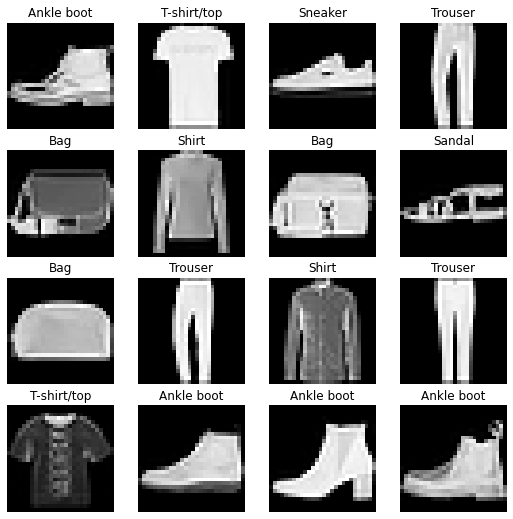

In [242]:
#Plotting some data out
import matplotlib.pyplot as plt
# Plot more images
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001F21ED37F40>, <torch.utils.data.dataloader.DataLoader object at 0x000001F2C7CB23A0>)
Length of train dataloader: 938 batches of 64
Length of test dataloader: 157 batches of 64
torch.Size([64, 1, 28, 28]) torch.Size([64])
Image size: torch.Size([1, 28, 28])
Label: 9, label size: torch.Size([])


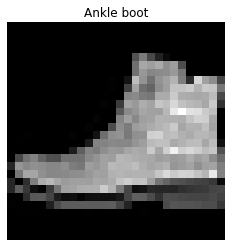

In [243]:
#Turning our dataSet into dataLoader to make it into batches
BATCH_SIZE = 64

train_dataloader = DataLoader(train_data,batch_size = BATCH_SIZE,shuffle = True)
test_dataloader  = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

#After every loading, remember to check what you have just done through Visualization
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader)) #<- iterator to next object in the dataSet
print(train_features_batch.shape, train_labels_batch.shape)
#torch.Size([32, 1, 28, 28]) = [batch_size,colour channel,height,width] torch.Size([32])

# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [244]:
from torch import nn

#Add a reshape layer into sequential
class Reshape(nn.Module):
    def __init__(self,*args):
        super(Reshape,self).__init__()
        self.shape = args

    def forward(self,x):
        return x.view((x.size(0),) + self.shape)

#Building the model
class LeNET5_V0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=32,kernel_size = 5,stride = 1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels = 64,kernel_size = 5,stride = 1,padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            #Note in order to pass to pass conv2d into a fully connected layer
            #One must first flatten with the size of previous layer.
            #Remember to check the input features.
            nn.Flatten(),
            nn.Linear(in_features = 7*7*64,out_features=120),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            # nn.Linear(in_features=1024,out_features=10),
            # nn.ReLU(),
            nn.Linear(in_features = 120,out_features=84),
            nn.ReLU(),
            nn.Linear(in_features = 84,out_features=10),
            nn.ReLU(),
            nn.Softmax()
        )

    def forward(self, x):
        return self.layer_stack(x)

# Install torchinfo if it's not available, import it if it is
#Using torchinfo to understand your model. Combining with tensorboard, it becomes even better
from torchinfo import summary

IMAGE_SIZE = 28
NUMBER_OF_CLASS = len(class_names)
print(NUMBER_OF_CLASS)

model_0 = LeNET5_V0(input_shape=1,output_shape = NUMBER_OF_CLASS).to(device)

summary(model_0,input_size = [32,1,28,28]) #<- batch_size,channels,height,width

10


Layer (type:depth-idx)                   Output Shape              Param #
LeNET5_V0                                [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          832
│    └─ReLU: 2-2                         [32, 32, 28, 28]          --
│    └─MaxPool2d: 2-3                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 14, 14]          51,264
│    └─ReLU: 2-5                         [32, 64, 14, 14]          --
│    └─MaxPool2d: 2-6                    [32, 64, 7, 7]            --
│    └─Flatten: 2-7                      [32, 3136]                --
│    └─Linear: 2-8                       [32, 120]                 376,440
│    └─ReLU: 2-9                         [32, 120]                 --
│    └─Dropout: 2-10                     [32, 120]                 --
│    └─Linear: 2-11                      [32, 84]                  10,164
│

In [245]:
#Build the function for training
from tqdm.auto import tqdm

NUM_EPOCHS = 100
LR = 0.3
loss_fn = nn.CrossEntropyLoss()

#Creating empty loss to track values
train_acccuracy_values = []
test_accuracy_values   = []
train_loss_values = []
test_loss_values = []
epoch_count = []

# Create training and testing loop
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch}\n-------")
    print(f"Current learning rate: {LR}")
    optimizer = torch.optim.SGD(params = model_0.parameters(),lr = LR)
    ### Training
    train_loss = 0
    train_acc = Accuracy().to(device)
    train_acccuracy = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        X = X.to(device)
        y = y.to(device)

        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        train_acccuracy += train_acc(y_pred,y)
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_acccuracy /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss,test_accuracy = 0,0
    test_acc  = Accuracy().to(device)
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:

            X = X.to(device)
            y = y.to(device)
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_accuracy += test_acc(test_pred,y)

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss     /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_accuracy /= len(test_dataloader)

    ## Print out what's happening
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acccuracy*100:.2f}%\n")
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy*100:.2f}%\n")

    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().to("cpu").numpy()) #<- must convert tensor back to numpy arr
    test_loss_values.append(test_loss.detach().to("cpu").numpy())

    train_acccuracy_values.append(train_acccuracy.detach().to("cpu").numpy())
    test_accuracy_values.append(test_accuracy.detach().to("cpu").numpy())

    #Adjust the Learning according to training result
    if epoch == 10:
        LR = 0.1
    elif epoch == 20:
        LR = 0.05
    elif epoch%10 & epoch>= 30:
        LR = LR - 0.005
    else:
        LR = LR

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Current learning rate: 0.3
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples
Train loss: 2.01782 | Train accuracy: 44.49%

Test loss: 1.85298 | Test accuracy: 60.80%

Epoch: 1
-------
Current learning rate: 0.3
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples
Train loss: 1.76332 | Train accuracy: 69.83%

Test loss: 1.73041 | Test accuracy: 73.07%

Epoch: 2
-------
Current learning rate: 0.3
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples
Train loss: 1.72857 | Train accuracy: 73.27%

Test loss: 1.71949 | Test accuracy: 74.03%

Epoch: 3
-------
Current learning rate: 0.3
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples
Train loss: 1.67180 | Train accuracy: 78.94%

Test loss: 1.61960 | Test accuracy: 84.08%

Epoch: 4
-------
Current learning rate: 0.3
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/6000

Making predictions:   0%|          | 0/157 [00:00<?, ?it/s]

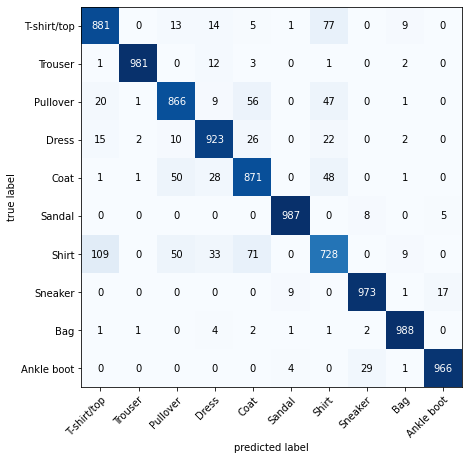

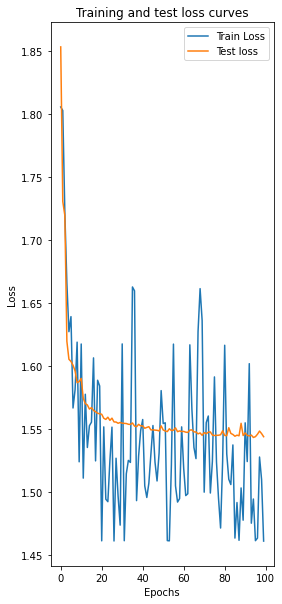

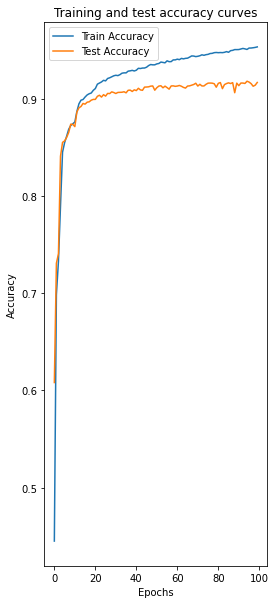

In [246]:
#Evaluating
#Visulatze the result with confusion matrix
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)

#Plotting the train loss curves and test loss curves
plt.figure(figsize = (4,10))
plt.plot(epoch_count, train_loss_values, label = "Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

#Plotting the accuracy curves and test accuracy curves
plt.figure(figsize = (4,10))
plt.plot(epoch_count, train_acccuracy_values, label = "Train Accuracy")
plt.plot(epoch_count, test_accuracy_values, label = "Test Accuracy")
plt.title("Training and test accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [247]:
#Saving the model for later use